# Strava Fitness Data Analytics — Case Study (Bellabeat)
**Author:** Gouri Sunil Kumar  
**Tools:** Python (pandas, matplotlib), Jupyter Notebook  
**Deliverables:** `.ipynb` notebook, exported PDF report, summary CSV, visuals  
---

**Objective:** Analyze Fitabase/Strava-style fitness data (activity, sleep, steps, weight) to extract actionable insights and high-level marketing recommendations for Bellabeat.

In [14]:
# 1) Setup & Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Display settings
pd.options.display.max_columns = 50
plt.rcParams['figure.dpi'] = 120
# Color palette (minimal + colorful)
COLORS = ['#4C72B0', '#55A868', '#DD8452', '#C44E52']  # blue, green, orange, red


In [15]:
# 2) Load datasets (works if CSV or XLSX present in the same folder)
filenames = {
    'activity': ['dailyActivity_merged.csv','dailyActivity_merged.xlsx','dailyActivity_merged.xls'],
    'sleep': ['sleepDay_merged.csv','sleepDay_merged.xlsx','sleepDay_merged.xls'],
    'steps': ['dailySteps_merged.csv','dailySteps_merged.xlsx','dailySteps_merged.xls'],
    'calories': ['dailyCalories_merged.csv','dailyCalories_merged.xlsx','dailyCalories_merged.xls'],
    'weight': ['weightLogInfo_merged.csv','weightLogInfo_merged.xlsx','weightLogInfo_merged.xls']
}

def find_and_load(name):
    for fname in filenames[name]:
        if os.path.exists(fname):
            if fname.lower().endswith(('.xls','.xlsx')):
                return pd.read_excel(fname)
            else:
                return pd.read_csv(fname)
    print(f"⚠️ Warning: none of the expected files for {name} found in the working directory. Tried: {filenames[name]}")
    return pd.DataFrame()

activity = find_and_load('activity')
sleep = find_and_load('sleep')
steps = find_and_load('steps')
calories = find_and_load('calories')
weight = find_and_load('weight')

print('Loaded shapes:')
print('activity', activity.shape)
print('sleep', sleep.shape)
print('steps', steps.shape)
print('calories', calories.shape)
print('weight', weight.shape)


Loaded shapes:
activity (940, 15)
sleep (413, 5)
steps (940, 3)
calories (940, 3)
weight (67, 8)


In [16]:
# 3) Quick head of each dataset (first 3 rows)
for df,name in [(activity,'Activity'),(sleep,'Sleep'),(steps,'Steps'),(calories,'Calories'),(weight,'Weight')]:
    print(f"--- {name} ({df.shape[0]} rows) ---")
    display(df.head(3))


--- Activity (940 rows) ---


,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776


--- Sleep (413 rows) ---


,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
0,1503960366,4/12/2016 12:00:00 AM,1,327,346
1,1503960366,4/13/2016 12:00:00 AM,2,384,407
2,1503960366,4/15/2016 12:00:00 AM,1,412,442


--- Steps (940 rows) ---


,Id,ActivityDay,StepTotal
0,1503960366,4/12/2016,13162
1,1503960366,4/13/2016,10735
2,1503960366,4/14/2016,10460


--- Calories (940 rows) ---


,Id,ActivityDay,Calories
0,1503960366,4/12/2016,1985
1,1503960366,4/13/2016,1797
2,1503960366,4/14/2016,1776


--- Weight (67 rows) ---


,Id,Date,WeightKg,WeightPounds,Fat,BMI,IsManualReport,LogId
0,1503960366,5/2/2016 11:59:59 PM,52.599998,115.963147,22.0,22.650000,True,1462233599000
1,1503960366,5/3/2016 11:59:59 PM,52.599998,115.963147,NaN,22.650000,True,1462319999000
2,1927972279,4/13/2016 1:08:52 AM,133.500000,294.317120,NaN,47.540001,False,1460509732000


In [17]:
# 4) Cleaning & type conversions
if not activity.empty and 'ActivityDate' in activity.columns:
    activity = activity.drop_duplicates().copy()
    activity['ActivityDate'] = pd.to_datetime(activity['ActivityDate'])
if not sleep.empty and 'SleepDay' in sleep.columns:
    sleep = sleep.drop_duplicates().copy()
    sleep['SleepDay'] = pd.to_datetime(sleep['SleepDay']).dt.normalize()
if not steps.empty and 'ActivityDay' in steps.columns:
    steps['ActivityDay'] = pd.to_datetime(steps['ActivityDay'])

for df,name in [(activity,'Activity'),(sleep,'Sleep')]:
    if not df.empty:
        print(f"{name} missing values:\n", df.isnull().sum().loc[lambda s: s>0])


Activity missing values:
 Series([], dtype: int64)
Sleep missing values:
 Series([], dtype: int64)


C:\Users\sunil\AppData\Local\Temp\ipykernel_60656\3683823272.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sleep['SleepDay'] = pd.to_datetime(sleep['SleepDay']).dt.normalize()


In [18]:
# 5) Basic statistics / KPIs
kpis = {}
if not activity.empty:
    kpis['Average Steps'] = activity['TotalSteps'].mean()
    kpis['Average Calories'] = activity['Calories'].mean()
    for col in ['VeryActiveMinutes','FairlyActiveMinutes','LightlyActiveMinutes','SedentaryMinutes']:
        if col in activity.columns:
            kpis.setdefault('Average ' + col, activity[col].mean())
if not sleep.empty and 'TotalMinutesAsleep' in sleep.columns:
    kpis['Average Sleep (min)'] = sleep['TotalMinutesAsleep'].mean()

kpi_df = pd.DataFrame([kpis]).T.rename(columns={0:'Value'})
kpi_df


,Value
Average Steps,7637.910638
Average Calories,2303.609574
Average VeryActiveMinutes,21.164894
Average FairlyActiveMinutes,13.564894
Average LightlyActiveMinutes,192.812766
Average SedentaryMinutes,991.210638
Average Sleep (min),419.173171


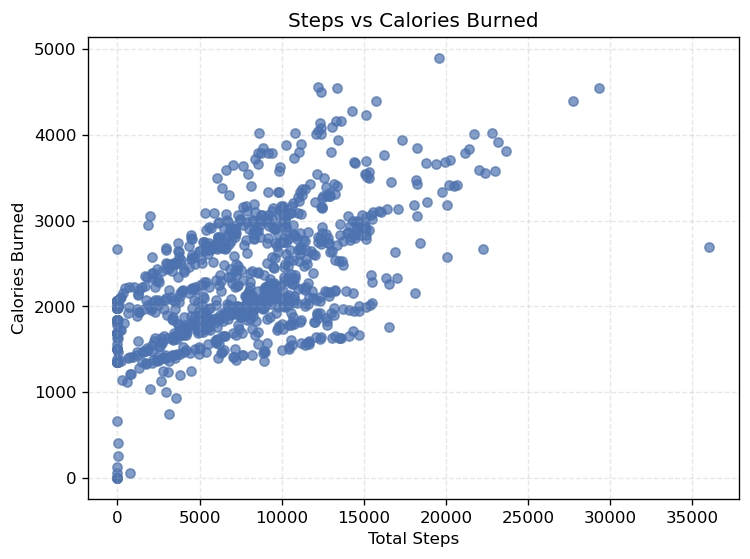

In [19]:
# 6) Visualization: Steps vs Calories
if not activity.empty and 'TotalSteps' in activity.columns and 'Calories' in activity.columns:
    fig, ax = plt.subplots(figsize=(7,5))
    ax.scatter(activity['TotalSteps'], activity['Calories'], alpha=0.7, s=30, c=COLORS[0])
    ax.set_xlabel('Total Steps')
    ax.set_ylabel('Calories Burned')
    ax.set_title('Steps vs Calories Burned')
    ax.grid(True, linestyle='--', alpha=0.3)
    plt.show()
else:
    print('Required columns for Steps vs Calories not found.')


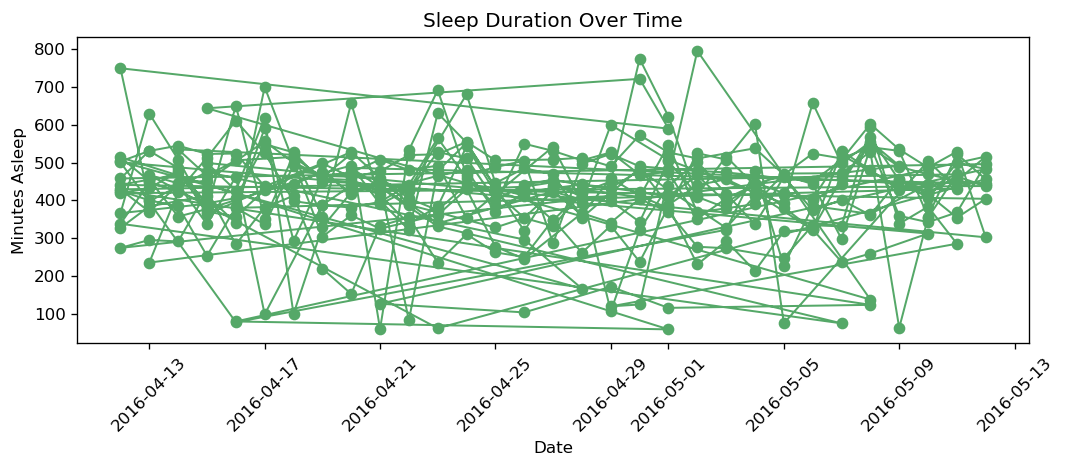

In [20]:
# 7) Visualization: Sleep Duration Over Time
if not sleep.empty and 'SleepDay' in sleep.columns and 'TotalMinutesAsleep' in sleep.columns:
    fig, ax = plt.subplots(figsize=(9,4))
    ax.plot(sleep['SleepDay'], sleep['TotalMinutesAsleep'], marker='o', linewidth=1.2, color=COLORS[1])
    ax.set_xlabel('Date')
    ax.set_ylabel('Minutes Asleep')
    ax.set_title('Sleep Duration Over Time')
    ax.grid(False)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('Sleep data not present for time-series.')


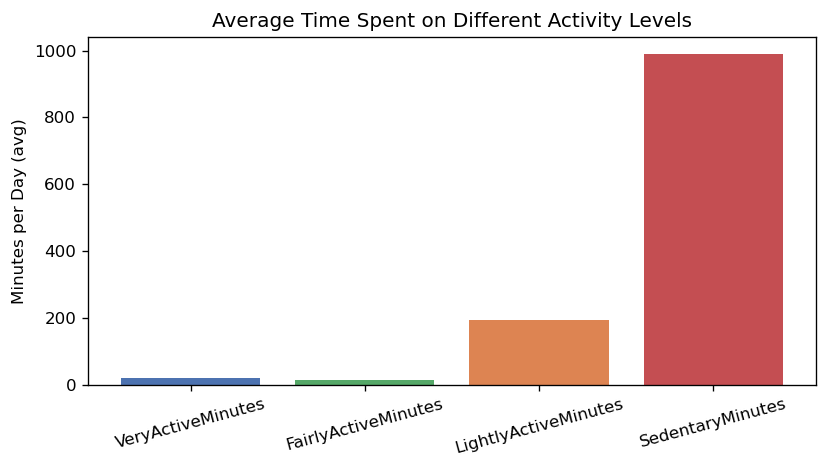

In [21]:
# 8) Visualization: Activity Breakdown (average minutes)
activity_cols = [c for c in ['VeryActiveMinutes','FairlyActiveMinutes','LightlyActiveMinutes','SedentaryMinutes'] if c in activity.columns]
if activity_cols:
    means = activity[activity_cols].mean()
    fig, ax = plt.subplots(figsize=(7,4))
    ax.bar(means.index, means.values, color=COLORS)
    ax.set_ylabel('Minutes per Day (avg)')
    ax.set_title('Average Time Spent on Different Activity Levels')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()
else:
    print('No activity minute columns found.')


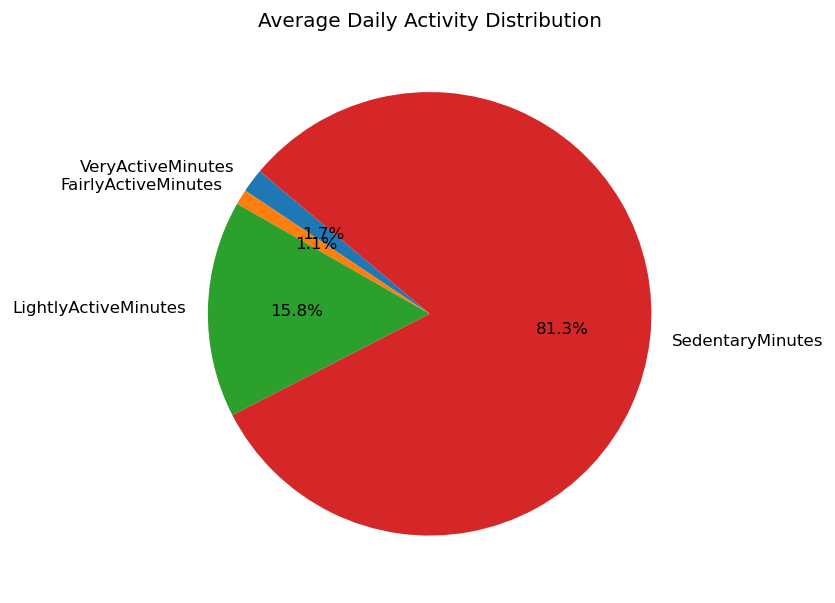

In [22]:
# 9) Visualization: Pie Chart for Activity Distribution
if activity_cols:
    fig, ax = plt.subplots(figsize=(6,6))
    ax.pie(means.values, labels=means.index, autopct='%1.1f%%', startangle=140)
    ax.set_title('Average Daily Activity Distribution')
    plt.show()


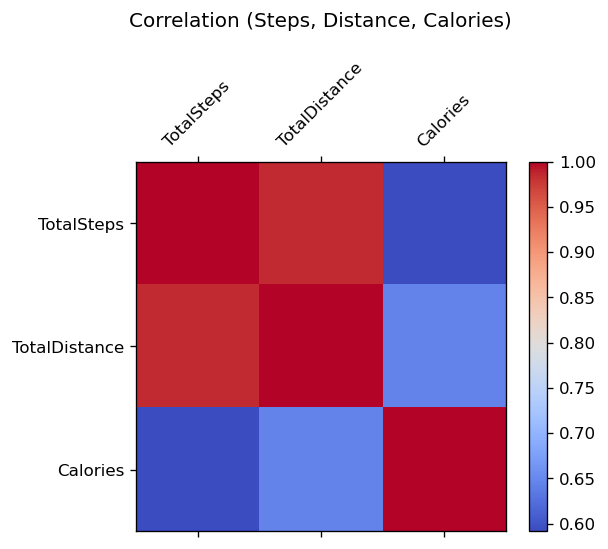

In [23]:
# 10) Correlation between Steps, Distance, Calories
cols = [c for c in ['TotalSteps','TotalDistance','Calories'] if c in activity.columns]
if len(cols) >= 2:
    corr = activity[cols].corr()
    fig, ax = plt.subplots(figsize=(5,4))
    cax = ax.matshow(corr, cmap='coolwarm')
    fig.colorbar(cax)
    ax.set_xticks(range(len(cols))); ax.set_yticks(range(len(cols)))
    ax.set_xticklabels(cols, rotation=45); ax.set_yticklabels(cols)
    ax.set_title('Correlation (Steps, Distance, Calories)', pad=20)
    plt.show()
else:
    print('Not enough columns for correlation matrix.')


Merged rows: 12535


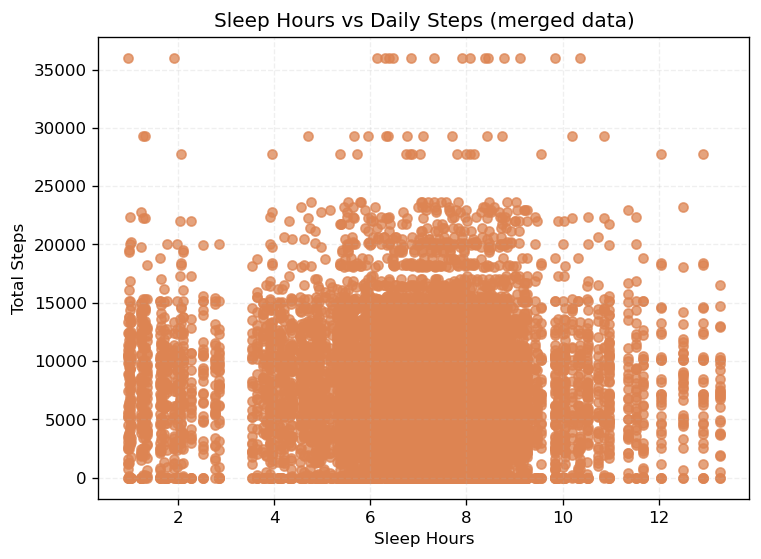

In [24]:
# 11) Merge activity and sleep for combined insights (by date)
if not activity.empty and not sleep.empty:
    merged = pd.merge(activity, sleep, left_on='ActivityDate', right_on='SleepDay', how='inner')
    merged['SleepHours'] = merged['TotalMinutesAsleep'] / 60.0
    print('Merged rows:', merged.shape[0])
    fig, ax = plt.subplots(figsize=(7,5))
    ax.scatter(merged['SleepHours'], merged['TotalSteps'], alpha=0.75, c=COLORS[2], s=30)
    ax.set_xlabel('Sleep Hours')
    ax.set_ylabel('Total Steps')
    ax.set_title('Sleep Hours vs Daily Steps (merged data)')
    ax.grid(True, linestyle='--', alpha=0.2)
    plt.show()
else:
    print('Either activity or sleep missing; cannot merge.')


In [25]:
# 12) KPI Display + Save summary CSV and multi-page PDF report of visuals
display(kpi_df)

summary_out = 'Strava_Fitness_Summary.csv'
kpi_df.to_csv(summary_out)
print('Saved summary CSV ->', summary_out)

pdf_path = 'Strava_Fitness_Report_Charts.pdf'
pp = PdfPages(pdf_path)
for i in plt.get_fignums():
    fig = plt.figure(i)
    pp.savefig(fig)
pp.close()
print('Saved charts PDF ->', pdf_path)


,Value
Average Steps,7637.910638
Average Calories,2303.609574
Average VeryActiveMinutes,21.164894
Average FairlyActiveMinutes,13.564894
Average LightlyActiveMinutes,192.812766
Average SedentaryMinutes,991.210638
Average Sleep (min),419.173171


Saved summary CSV -> Strava_Fitness_Summary.csv
Saved charts PDF -> Strava_Fitness_Report_Charts.pdf


C:\Users\sunil\AppData\Local\Temp\ipykernel_60656\3693135740.py:13: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed in 3.10.
  pp.close()


## Insights & Recommendations

**Key Insights (example):**
- Average daily steps indicate users are _below_ the WHO target (10,000 steps). Consider targeted nudges.
- Steps and calories show a strong positive correlation — active minutes are effective for calorie burn.
- Sleep duration varies; explore personalized reminders for consistent sleep schedule.
- High sedentary minutes indicate an opportunity for micro-activity reminders and in-app challenges.

**Recommendations for Bellabeat (high-level):**
1. Introduce in-app micro-challenges (7-day step challenges) with social sharing.  
2. Use personalized push notifications for users with high sedentary minutes.  
3. Offer sleep-focused content and features for users with inconsistent sleep patterns.
4. Leverage insights to create targeted marketing campaigns (e.g., "Boost your daily steps in 10 minutes").

---

**How to export for submission:**

1. Run all cells, then `File -> Download as -> PDF` or use the generated `Strava_Fitness_Report_Charts.pdf` and the notebook `.ipynb`.  
2. Submit both `.ipynb` and the PDF on Labmentix portal (or zip them together).  
3. For LinkedIn: Create a short post describing key finding + attach PDF or screenshots of 2–3 charts.